# Consolidation test - poroelasticity

### Install dependencies

Bring fenicsx to the environement.
It takes 1-2 minutes to run.

In [ ]:
release = "prod"
arch = "real"

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl
    import dolfinx
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        if release != "development":
            if arch != "complex":
                !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            else:
                !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        else:
            if arch != "complex":
                !wget "https://fem-on-colab.github.io/releases/fenicsx-install-development-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            else:
                !wget "https://fem-on-colab.github.io/releases/fenicsx-install-development-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        import ufl
        import dolfinx

try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

### Import all dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import ipywidgets as widgets
from IPython.display import display

from mpi4py import MPI
from dolfinx import mesh, fem
import ufl
from basix.ufl import element, mixed_element

### Build mesh

We are using a simple generator from fenicsx environment.
For nicer meshes, I suggest using gmsh.

In [ ]:
# ------------------ Mesh ------------------
NX, NY = 10, 10
domain = mesh.create_unit_square(MPI.COMM_WORLD, NX, NY)
cell_name = domain.topology.cell_name()

# ------------------ Function Space ------------------
P2 = element("Lagrange", cell_name, 2, shape=(domain.geometry.dim,))
P1 = element("Lagrange", cell_name, 1)
melem = mixed_element([P2, P1])
V = fem.functionspace(domain, melem)

# ------------------ Boundary conditions ------------------
LEFT, RIGHT, BOTTOM, TOP = 1, 2, 3, 4

def is_boundary(x, bname):
    if bname == "left": return np.isclose(x[0], 0.0)
    if bname == "right": return np.isclose(x[0], 1.0)
    if bname == "bottom": return np.isclose(x[1], 0.0)
    if bname == "top": return np.isclose(x[1], 1.0)

fdim = domain.topology.dim - 1
boundaries = {"left": LEFT, "right": RIGHT, "bottom": BOTTOM, "top": TOP}

facet_indices = []
facet_values = []

for name, tag in boundaries.items():
    facets = mesh.locate_entities_boundary(domain, fdim, lambda x, n=name: is_boundary(x, n))
    facet_indices.extend(facets)
    facet_values.extend([tag]*len(facets))

facet_indices = np.array(facet_indices, dtype=np.int32)
facet_values = np.array(facet_values, dtype=np.int32)
sorted_order = np.argsort(facet_indices)
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_order], facet_values[sorted_order])
domain.topology.create_connectivity(fdim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, fdim)

ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

### Material properties and constitutive equations

In [ ]:
# ------------------ Material parameters ------------------
E = 1e9           # Pa
nu = 0.3
alpha = 1.0
K_fluid = 2e9     # Pa
phi = 0.2
perm = 1e-11      # m^2
visc = 1e-3       # Pa.s
dt = 1e-5         # s
num_steps = 50    # Reduce for Colab speed

lmbda = E*nu / ((1+nu)*(1-2*nu))
mu = E/(2*(1+nu))
M = K_fluid / phi
kappa = perm / visc

def eps(u):
    return ufl.sym(ufl.grad(u))
def eps_v(u):
    return ufl.tr(eps(u))
def sigma_eff(u):
    return lmbda*ufl.tr(eps(u))*ufl.Identity(2) + 2*mu*eps(u)

# ------------------ Weak form ------------------
def weak_form(up_old, dt):
    u, p = ufl.TrialFunctions(V)
    v, q = ufl.TestFunctions(V)
    u_old, p_old = ufl.split(up_old)
    dx = ufl.dx(domain)

    a = (
        ufl.inner(sigma_eff(u), eps(v))*dx
        - alpha*p*eps_v(v)*dx
        + alpha*eps_v(u)*q*dx
        + dt*kappa*ufl.inner(ufl.grad(p), ufl.grad(q))*dx
        + (1.0/M)*p*q*dx
    )
    L = (
        alpha*eps_v(u_old)*q*dx
        + (1.0/M)*p_old*q*dx
        - fem.Constant(domain, 1.0e6)*v[1]*ds(TOP)   # BOUNDARY CONSTRAINT! VERTICAL STRESS AT THE TOP
    )
    return a, L

### Buondary conditions

In [ ]:
# ------------------ Dirichlet BCs ------------------
UX, _ = V.sub(0).sub(0).collapse()
UY, _ = V.sub(0).sub(1).collapse()
P,  _ = V.sub(1).collapse()

zero_u = fem.Function(UX)
zero_v = fem.Function(UY)
zero_p = fem.Function(P)

bcs_data = [
    (LEFT, UX, zero_u, V.sub(0).sub(0)),
    (RIGHT, UX, zero_u, V.sub(0).sub(0)),
    (BOTTOM, UY, zero_v, V.sub(0).sub(1)),
    (TOP, P, zero_p, V.sub(1)),
]

bcs = []
for tag, space, value, parent in bcs_data:
    facets = facet_tags.find(tag)
    dofs = fem.locate_dofs_topological((parent, space), fdim, facets)
    bcs.append(fem.dirichletbc(value, dofs, parent))

#### Time loop

In [ ]:
# ------------------ Solution functions ------------------
up = fem.Function(V)
up_old = fem.Function(V)

U, U_to_V = V.sub(0).collapse()
P_space, P_to_V = V.sub(1).collapse()

u_out = fem.Function(U)
p_out = fem.Function(P_space)

# ------------------ Store pressure snapshots ------------------
pressure_list = []
displacement_list = []
time_list = []
# ------------------ Time loop ------------------
from dolfinx.fem.petsc import LinearProblem
time = 0
dt = 1e-3
kdt = 1.3
dtmax = 1

for step in range(num_steps):
    time_list.append(time)

    a, L = weak_form(up_old, dt)
    problem = LinearProblem(
        a, L,
        bcs=bcs,
        petsc_options={"ksp_type":"preonly", "pc_type":"lu"},
        petsc_options_prefix="test"
    )
    up.x.array[:] = problem.solve().x.array[:]

    u_out.x.array[:] = up.x.array[U_to_V]
    p_out.x.array[:] = up.x.array[P_to_V]

    # Save pressure for interactive plotting
    pressure_copy = fem.Function(P_space)
    pressure_copy.x.array[:] = p_out.x.array
    pressure_list.append(pressure_copy)

    displacement_copy = fem.Function(U)
    displacement_copy.x.array[:] = u_out.x.array[:]
    displacement_list.append(displacement_copy)

    # Advance previous step
    up_old.x.array[:] = up.x.array

    if domain.comm.rank == 0:
        print(f"Step {step+1}/{num_steps}   time = {step*dt:.3e}")

    dt = min( dtmax, dt*kdt )
    time += dt


Step 1/50   time = 0.000e+00
Step 2/50   time = 1.300e-03
Step 3/50   time = 3.380e-03
Step 4/50   time = 6.591e-03
Step 5/50   time = 1.142e-02
Step 6/50   time = 1.856e-02
Step 7/50   time = 2.896e-02
Step 8/50   time = 4.392e-02
Step 9/50   time = 6.526e-02
Step 10/50   time = 9.544e-02
Step 11/50   time = 1.379e-01
Step 12/50   time = 1.971e-01
Step 13/50   time = 2.796e-01
Step 14/50   time = 3.937e-01
Step 15/50   time = 5.512e-01
Step 16/50   time = 7.678e-01
Step 17/50   time = 1.065e+00
Step 18/50   time = 1.471e+00
Step 19/50   time = 2.024e+00
Step 20/50   time = 2.778e+00
Step 21/50   time = 3.801e+00
Step 22/50   time = 5.188e+00
Step 23/50   time = 7.066e+00
Step 24/50   time = 9.603e+00
Step 25/50   time = 1.303e+01
Step 26/50   time = 1.764e+01
Step 27/50   time = 2.385e+01
Step 28/50   time = 2.700e+01
Step 29/50   time = 2.800e+01
Step 30/50   time = 2.900e+01
Step 31/50   time = 3.000e+01
Step 32/50   time = 3.100e+01
Step 33/50   time = 3.200e+01
Step 34/50   time =

### Post processing

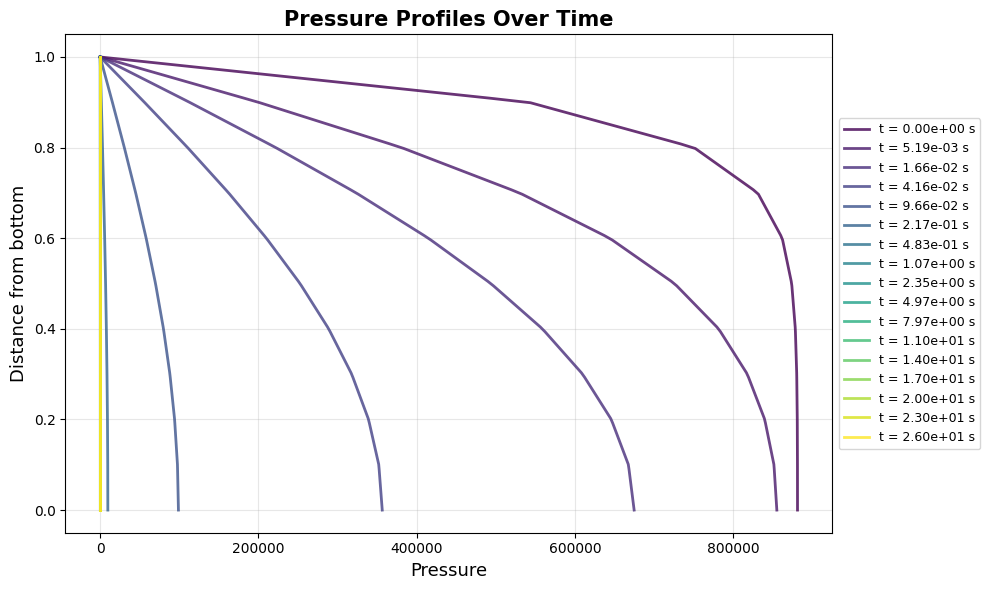

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.cm as cm


# Setup
x = domain.geometry.x
x_profile = (x[:,0].min() + x[:,0].max()) / 2
y_min = x[:,1].min()
y_max = x[:,1].max()

n_points = 100
y_profile = np.linspace(y_min, y_max, n_points)
distance_from_bottom = y_profile - y_min
profile_points = np.column_stack([np.full(n_points, x_profile), y_profile])

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot every 5th timestep
steps_to_plot = list(range(0, len(time_list), 3))
colors = cm.viridis(np.linspace(0, 1, len(steps_to_plot)))

for idx, step in enumerate(steps_to_plot):
    # Pressure profile
    pressure_interp = LinearNDInterpolator(x[:, :2], pressure_list[step].x.array)
    pressure_profile = pressure_interp(profile_points)

    label = f't = {time_list[step]:.2e} s'
    ax.plot(pressure_profile, distance_from_bottom, color=colors[idx],
            linewidth=2, label=label, alpha=0.8)

# Format plot
ax.set_xlabel('Pressure', fontsize=13)
ax.set_ylabel('Distance from bottom', fontsize=13)
ax.set_title('Pressure Profiles Over Time', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)

# Legend to the right, outside the plot area
ax.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

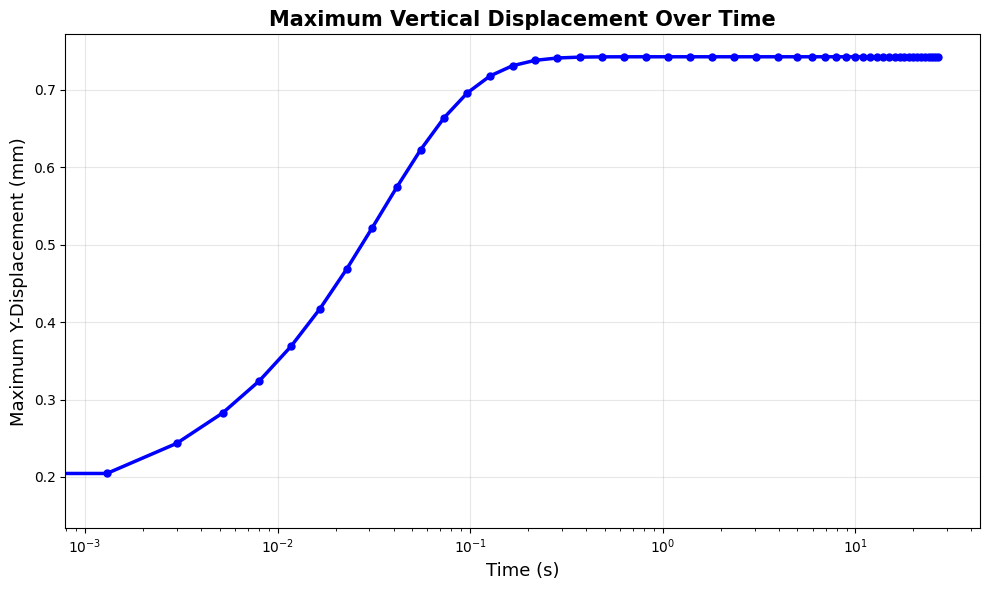

Final maximum vertical displacement: 0.7429 mm at t = 2.70e+01 s
Initial maximum vertical displacement: 0.1628 mm at t = 0.00e+00 s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract maximum v for each timestep
max_v_list = []
for disp in displacement_list:
    v = disp.x.array[1::2]  # y-displacement
    max_v_list.append(np.max(np.abs(v)))

# Convert to mm
max_v_mm = np.array(max_v_list) * 1000
time_array = np.array(time_list)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(time_array, max_v_mm, 'b-o', linewidth=2.5, markersize=5)

ax.set_xlabel('Time (s)', fontsize=13)
ax.set_ylabel('Maximum Y-Displacement (mm)', fontsize=13)
ax.set_title('Maximum Vertical Displacement Over Time', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
plt.tight_layout()
plt.show()

print(f"Final maximum vertical displacement: {max_v_mm[-1]:.4f} mm at t = {time_array[-1]:.2e} s")
print(f"Initial maximum vertical displacement: {max_v_mm[0]:.4f} mm at t = {time_array[0]:.2e} s")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import ipywidgets as widgets
import numpy as np

# ------------------ Triangulation for plotting ------------------
x = domain.geometry.x
cells = domain.topology.connectivity(domain.topology.dim, 0).array
num_cells = domain.topology.index_map(domain.topology.dim).size_local
triangles = cells.reshape((num_cells, 3))
triang = tri.Triangulation(x[:,0], x[:,1], triangles)

# ------------------ Precompute min/max pressure ------------------
all_p_values = []
for p in pressure_list:
    all_p_values.append(p.x.array)
all_p_values = np.concatenate(all_p_values)

p_min = np.min(all_p_values)
p_max = np.max(all_p_values)

print(f"Global p_min: {p_min}")
print(f"Global p_max: {p_max}")

# ------------------ Plot function ------------------
def plot_pressure(step):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Explicit levels for consistent color mapping
    levels = np.linspace(p_min, p_max, 51)

    # Plot filled contours
    contour = ax.tricontourf(triang, pressure_list[step].x.array,
                             levels=levels, vmin=p_min, vmax=p_max,
                             cmap='viridis', extend='both')

    # Plot mesh skeleton (triangle edges)
    ax.triplot(triang, 'k-', linewidth=0.3, alpha=0.4)

    # Colorbar
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('Pressure', rotation=270, labelpad=20)

    ax.set_aspect("equal")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Pore Pressure at step {step+1} (t = {time_list[step]:.4f} s)')

    plt.tight_layout()
    plt.show()

# ------------------ Interactive widget ------------------
widgets.interact(
    plot_pressure,
    step=widgets.IntSlider(
        value=0,
        min=0,
        max=num_steps-1,
        step=1,
        description='Time Step:',
        continuous_update=False,
        layout=widgets.Layout(width='600px')
    )
)

Global p_min: -8.473773717906414e-20
Global p_max: 1.2160729022172014


interactive(children=(IntSlider(value=0, continuous_update=False, description='Time Step:', layout=Layout(widt…

<function __main__.plot_pressure(step)>